# **Exercise 2**

In [1]:
import numpy as np
import spacy
import requests
import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_recall_curve, auc, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


# Load the spaCy model with pre-trained word embeddings
word_embeddings = spacy.load("en_core_web_sm")

def download_and_read_data(file_url, size):
    response = requests.get(file_url)
    lines = response.text.splitlines()
    sentences = []
    current_sentence = []

    for line in lines:
        if line.startswith('#') or line == '':
            if current_sentence:
                sentences.append(current_sentence)
                current_sentence = []
                if(len(sentences) == size):
                    break
        else:
            parts = line.split('\t')
            if len(parts) > 3:
                current_sentence.append((parts[1], parts[3]))  # (word, pos_tag)
    return sentences if not current_sentence else sentences + [current_sentence]

# URLs
train_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu"
dev_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu"
test_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"

# Read and preprocess data
subset_size = 1000
train_data = download_and_read_data(train_url, subset_size)
dev_data = download_and_read_data(dev_url, int(subset_size/5))
test_data = download_and_read_data(test_url, int(subset_size/5))

# Extract words and POS tags
def extract_features(sentence, i):
    word = sentence[i][0]
    pos = sentence[i][1]

    # # Features: the current word and its two neighbors
    # features = [
    #     word,
    #     sentence[i - 1][0] if i > 0 else '*PAD*',
    #     sentence[i + 1][0] if i < len(sentence) - 1 else '*PAD*',
    # ]
    # return features, pos
    return [word], pos

# Create training, development, and test datasets
def create_dataset(data):
    X, y = [], []
    for sentence in data:
        X_sentence = []
        y_sentence = []
        for i in range(len(sentence)):
            features, pos = extract_features(sentence, i)
            #X_sentence.append(features)
            X.append(features)
            y.append(pos)
        #X.append(X_sentence)
        #y.append(y_sentence)
    return X, y


X_train, y_train = create_dataset(train_data)
X_dev, y_dev = create_dataset(dev_data)
X_test, y_test = create_dataset(test_data)


X_train_embed = []
X_dev_embed = []
X_test_embed = []

# Convert words to spaCy word vectors
for dataset, X_embed in zip([X_train, X_dev, X_test], [X_train_embed, X_dev_embed, X_test_embed]):
    for sentence in tqdm.tqdm(range(len(dataset))):
        word_vectors = [word_embeddings(word).vector for word in dataset[sentence]]
        X_embed.append(np.array(word_vectors))


# Encode POS tags
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
num_classes = len(label_encoder.classes_)

y_train_encoded = label_encoder.transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)
y_test_encoded = label_encoder.transform(y_test)


# Convert tags to one-hot encoding
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_dev_onehot = to_categorical(y_dev_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

# constants
embedding_dim = word_embeddings('test').vector.shape[0]


# statistics
print("Training set size:", len(train_data))
print("Development set size:", len(dev_data))
print("Test set size:", len(test_data))
lengths = [len(i) for i in train_data] + [len(i) for i in dev_data] + [len(i) for i in test_data]
print("Average sentence length: ", sum(lengths)/len(lengths))
words_set = set()
for sentences in zip([train_data, dev_data, test_data]):
    for sent in sentences:
        for w in sent:
            words_set.add(w[0])
print("NUmber of words: ", len(words_set))
print("Vocabulary size: ", len(word_embeddings.vocab))

del word_embeddings

100%|██████████| 4321/4321 [00:23<00:00, 185.38it/s]

Training set size: 1000
Development set size: 200
Test set size: 200
Average sentence length:  21.79
NUmber of words:  492
Vocabulary size:  6430


# **Find best hyperparameters**

In [ ]:
def evaluate_model(hidden_units, dropout_rate, lr, epochs, stacked_l):
  model = Sequential()
  for _ in range(stacked_l-1):
      model.add(Bidirectional(LSTM(units=hidden_units, return_sequences=True)))
      model.add(Dropout(dropout_rate))

  model.add(Bidirectional(LSTM(units=hidden_units, return_sequences=False)))
  model.add(Dropout(dropout_rate))

  model.add(Dense(num_classes, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

  filepath = 'temp_best_model.hdf5'
  checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',
                              verbose=0, save_best_only=True, mode='min')
  callbacks = [checkpoint]


  history = model.fit(np.array(X_train_embed, dtype='float32'), y_train_onehot, epochs=epochs,
                      validation_data=(np.array(X_dev_embed, dtype='float32'), y_dev_onehot),
                      callbacks=callbacks, batch_size=32, verbose = 0)


  loss, accuracy = model.evaluate(np.array(X_dev_embed), y_dev_onehot)
  del model
  del history
  return accuracy, loss

def tune_hyperparam(params):
  best_acc = 0
  best_loss = 100
  best_params = ()
  for hdu in params["hidden_units"]:
    for dro in params["dropout_rate"]:
      for lr in params["learning_rate"]:
        for ep in params["epochs"]:
          for sl in params["stacked_layers"]:
            print("Dev accuracy for params: ", (hdu, dro, lr, ep, sl))
            acc, loss = evaluate_model(hdu, dro, lr, ep, sl)
            if loss < best_loss or (loss == best_loss and acc > best_acc):
              best_acc = acc
              best_loss = loss
              best_params = (hdu, dro, lr, ep, sl)

  return best_acc, best_loss, best_params

hyper_parameters = {
    "hidden_units": [64, 128, 256],
    "dropout_rate": [0.2, 0.4, 0.6],
    "learning_rate": [0.0001, 0.001, 0.01],
    "epochs": [50],
    "stacked_layers": [3, 4, 5]
}

print(tune_hyperparam(hyper_parameters))

Dev accuracy for params:  (128, 0.2, 0.0001, 50, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


128/128 [==============================] - 1s 5ms/step - loss: 0.2786 - accuracy: 0.9097
Dev accuracy for params:  (128, 0.2, 0.0001, 50, 4)
128/128 [==============================] - 1s 6ms/step - loss: 0.2803 - accuracy: 0.9088
Dev accuracy for params:  (128, 0.2, 0.0001, 50, 5)
128/128 [==============================] - 1s 6ms/step - loss: 0.2842 - accuracy: 0.9080
Dev accuracy for params:  (128, 0.2, 0.001, 50, 3)
128/128 [==============================] - 1s 5ms/step - loss: 0.4135 - accuracy: 0.9016
Dev accuracy for params:  (128, 0.2, 0.001, 50, 4)
128/128 [==============================] - 1s 6ms/step - loss: 0.4151 - accuracy: 0.8918
Dev accuracy for params:  (128, 0.2, 0.001, 50, 5)
128/128 [==============================] - 1s 7ms/step - loss: 0.3879 - accuracy: 0.9006
Dev accuracy for params:  (128, 0.2, 0.01, 50, 3)
128/128 [==============================] - 1s 5ms/step - loss: 0.3176 - accuracy: 0.9004
Dev accuracy for params:  (128, 0.2, 0.01, 50, 4)
128/128 [===========

# **Build model**

Epoch 1/100
688/692 [============================>.] - ETA: 0s - loss: 1.6671 - accuracy: 0.6093
Epoch 1: val_loss improved from inf to 0.63320, saving model to best_model.hdf5
692/692 [==============================] - 27s 14ms/step - loss: 1.6617 - accuracy: 0.6104 - val_loss: 0.6332 - val_accuracy: 0.8325
Epoch 2/100
 12/692 [..............................] - ETA: 6s - loss: 0.6501 - accuracy: 0.8333

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


690/692 [============================>.] - ETA: 0s - loss: 0.5131 - accuracy: 0.8587
Epoch 2: val_loss improved from 0.63320 to 0.40134, saving model to best_model.hdf5
692/692 [==============================] - 9s 13ms/step - loss: 0.5134 - accuracy: 0.8585 - val_loss: 0.4013 - val_accuracy: 0.8743
Epoch 3/100
690/692 [============================>.] - ETA: 0s - loss: 0.3931 - accuracy: 0.8836
Epoch 3: val_loss improved from 0.40134 to 0.35022, saving model to best_model.hdf5
692/692 [==============================] - 7s 10ms/step - loss: 0.3930 - accuracy: 0.8837 - val_loss: 0.3502 - val_accuracy: 0.8864
Epoch 4/100
687/692 [============================>.] - ETA: 0s - loss: 0.3533 - accuracy: 0.8917
Epoch 4: val_loss improved from 0.35022 to 0.32562, saving model to best_model.hdf5
692/692 [==============================] - 8s 12ms/step - loss: 0.3538 - accuracy: 0.8917 - val_loss: 0.3256 - val_accuracy: 0.8992
Epoch 5/100
692/692 [==============================] - ETA: 0s - loss: 0.

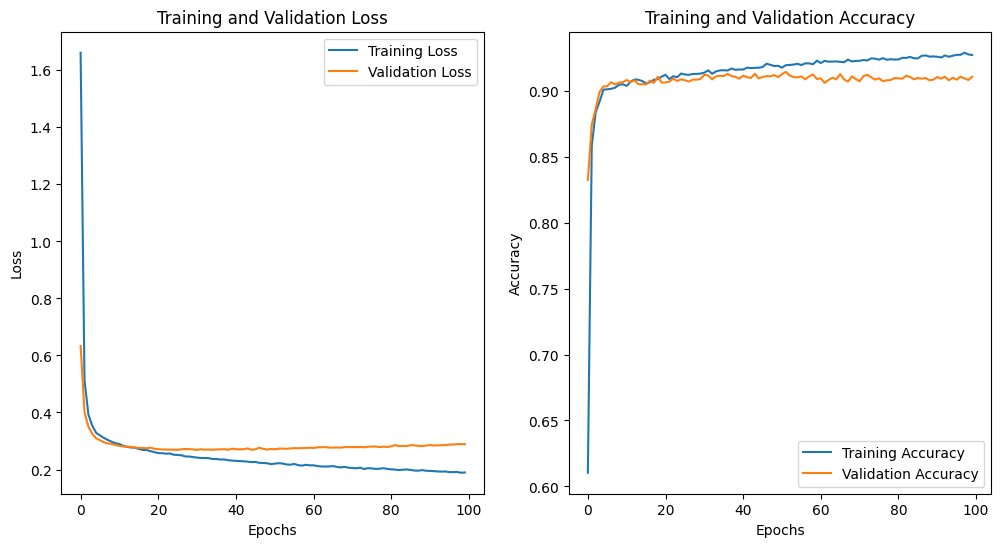

In [2]:
from tensorflow.keras.layers import Reshape

# Build the RNN model
units = 64
dropout_rate = 0.2
epochs = 100
learn_rate = 0.0001
num_layers = 3

model = Sequential()
for _ in range(num_layers-1):
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
model.add(Dropout(dropout_rate))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=learn_rate), loss='categorical_crossentropy', metrics=['accuracy'])

filepath = 'best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',
                            verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint]


history = model.fit(np.array(X_train_embed, dtype='float32'), y_train_onehot, epochs=epochs,
                    validation_data=(np.array(X_dev_embed, dtype='float32'), y_dev_onehot),
                    callbacks=callbacks, batch_size=32)

loss_list = history.history['val_loss']
print("Min validation loss at epoch: ", loss_list.index(min(loss_list)), "->", min(loss_list))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(np.array(X_test_embed), y_test_onehot)
print(f'\nTest Accuracy: {accuracy * 100:.2f}%')

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Calculate metrics**

In [3]:
import pandas as pd


def calculate_metrics(custom_model, X, y):
  # X = X_test_embed, y = y_test_onehot
  y_pred_class = custom_model.predict(np.array(X))
  report = classification_report(np.argmax(y, axis=1), np.argmax(y_pred_class, axis=1), output_dict=True)
  n_classes = y.shape[1]

  # For each class
  for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y[:, i], y_pred_class[:, i])
    try:
      report[str(i)]["pr-auc"] = auc(recall, precision)
    except:
      report[str(i)] = {"precision": 0, "recall": 0, "f1-score": 0, "pr-auc": auc(recall, precision), "support": 0}

  # A "macro-average": quantifying score on all classes jointly
  precision, recall, _ = precision_recall_curve(y.ravel(), y_pred_class.ravel())
  report["macro avg"]["pr-auc"] = auc(recall, precision)
  report["accuracy"] = {"precision": '', "recall": '', "f1-score": report["accuracy"], "pr-auc": '', "support": 0}
  #del report["weighted avg"]

  pd.set_option('display.precision', 4)
  final_report = pd.DataFrame.from_dict(report).T
  final_report["support"] = final_report["support"].astype(int)
  final_report = final_report.reindex(columns=["precision", "recall", "f1-score", "pr-auc", "support"])
  return final_report


for name, X_set, y_set in zip(["Training", "Development", "Test"],
                              [X_train_embed, X_dev_embed, X_test_embed],
                              [y_train_onehot, y_dev_onehot, y_test_onehot]):
  print("\nMetrics for", name, "dataset:")
  print(calculate_metrics(model, X_set, y_set))


Metrics for Training dataset:
692/692 [==============================] - 6s 5ms/step
             precision  recall f1-score  pr-auc  support
0               0.9397  0.9194   0.9294  0.9834     1626
1               0.9002  0.9026   0.9014  0.9495     2259
2               0.9165  0.8631    0.889  0.9613      979
3               0.8826  0.9707   0.9246  0.9665     1193
4               0.9836     1.0   0.9917  0.9998      660
5               0.9762  0.9712   0.9737  0.9974     1942
6                  1.0  0.5926   0.7442  0.7979       27
7               0.9497  0.9401   0.9449  0.9879     3491
8               0.9543     1.0   0.9766  0.9978      313
9               0.7049  0.9913    0.824  0.8815      576
10              0.9673  0.8986   0.9317   0.987     1252
11              0.9644  0.9836   0.9739  0.9962     2311
12              0.9945  0.9996   0.9971  0.9998     2551
13              0.6658  0.6214   0.6429  0.6732      420
14                 0.9  0.4737   0.6207  0.6489       19
15

# **Baseline Classifier and metrics**

In [4]:
flatten = lambda l: [item for sublist in l for item in sublist]

# Flatten and extract words and POS tags
train_flat = flatten(train_data)
train_words, train_tags = zip(*train_flat)
dev_flat = flatten(dev_data)
dev_words, dev_tags = zip(*dev_flat)
test_flat = flatten(test_data)
test_words, test_tags = zip(*test_flat)


class Majority_Classifier:
  def __init__(self):
    self.most_common_tag = None
    self.words = []
    self.tags = []
    self.label_encoder = LabelEncoder()
    self.num_classes = 0

  def fit(self, training_data):
    tag_counter = Counter(training_data)
    self.most_common_tag = tag_counter.most_common(1)[0][0][1]
    for word in tag_counter.keys():
      self.words.append(word[0])
      self.tags.append(word[1])

    self.label_encoder.fit(self.tags)
    self.num_classes = len(label_encoder.classes_)

    del tag_counter

  def predict(self, data):
    data, _ = zip(*data)
    predictions = []
    for word in data:
      try:
        pred_tag = self.tags[self.words.index(word)]
      except:
        pred_tag = self.most_common_tag
      predictions.append(pred_tag)
    return to_categorical(self.label_encoder.transform(predictions), self.num_classes)

majority = Majority_Classifier()
majority.fit(train_flat)

train_tags = to_categorical(majority.label_encoder.transform(train_tags), majority.num_classes)
dev_tags = to_categorical(majority.label_encoder.transform(dev_tags), majority.num_classes)
test_tags = to_categorical(majority.label_encoder.transform(test_tags), majority.num_classes)


for name, X_set, y_set in zip(["Training", "Development", "Test"],
                              [train_flat, dev_flat, test_flat],
                              [train_tags, dev_tags, test_tags]):
  print("\nMetrics for", name, "dataset:")
  print(calculate_metrics(majority, X_set, y_set))


Metrics for Training dataset:
             precision  recall f1-score  pr-auc  support
0               0.9482  0.9459    0.947   0.949     1626
1               0.9143  0.8645   0.8887  0.8964     2259
2               0.8909   0.859   0.8747  0.8781      979
3               0.8051  0.8692    0.836  0.8407     1193
4               0.9939  0.9879   0.9909  0.9911      660
5               0.9775  0.9398   0.9583  0.9613     1942
6                 0.88  0.8148   0.8462  0.8475       27
7               0.9659   0.957   0.9614  0.9648     3491
8               0.9965  0.9201   0.9568  0.9589      313
9               0.6867  0.7917   0.7355  0.7419      576
10              0.9331  0.9137   0.9233  0.9259     1252
11              0.9879  0.9905   0.9892  0.9897     2311
12              0.9926     1.0   0.9963  0.9963     2551
13              0.5245  0.6381   0.5757  0.5847      420
14                 1.0  0.2105   0.3478  0.6056       19
15              0.8927  0.9065   0.8995  0.9042     2193


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif